In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [23]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("../data/PlantVillage",
                                                              shuffle=True,
                                                              image_size=(IMG_SIZE,IMG_SIZE),
                                                              batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [9]:
class_name = dataset.class_names

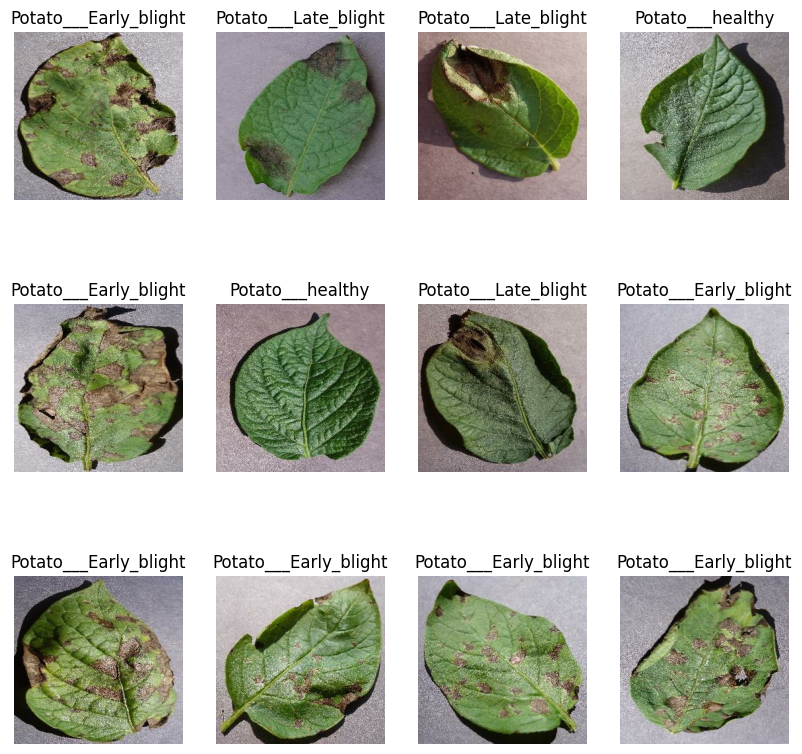

In [22]:
plt.figure(figsize=(10,10))
for img_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype('int'))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

In [25]:
len(dataset) * 0.8

54.400000000000006

In [26]:
train_dataset = dataset.take(54)

In [27]:
temp = dataset.skip(54)

In [30]:
len(dataset) * 0.1

6.800000000000001

In [31]:
validate_dataset = temp.take(6)

In [32]:
test_dataset = temp.skip(6)

In [35]:
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validate_dataset = validate_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0/255)
])

In [43]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [57]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL)
n_classes = len(class_name)
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [58]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validate_dataset,
    epochs=10  # Adjust the number of epochs as needed
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5117 - loss: 0.9227 - val_accuracy: 0.6823 - val_loss: 0.7492
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8271 - loss: 0.5281 - val_accuracy: 0.8542 - val_loss: 0.4490
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8463 - loss: 0.3988 - val_accuracy: 0.8958 - val_loss: 0.2623
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 810ms/step - accuracy: 0.8953 - loss: 0.2580 - val_accuracy: 0.8594 - val_loss: 0.3903
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 766ms/step - accuracy: 0.8797 - loss: 0.2831 - val_accuracy: 0.9323 - val_loss: 0.1424
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 827ms/step - accuracy: 0.9345 - loss: 0.1878 - val_accuracy: 0.8854 - val_loss: 0.3052
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 840ms/step - accuracy: 0.9200 - loss: 0.2175 - val_accuracy: 0.9323 - val_loss: 0.1625
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 907ms/step - accuracy: 0.9293 - loss: 0.1812 - val_accuracy: 0.8

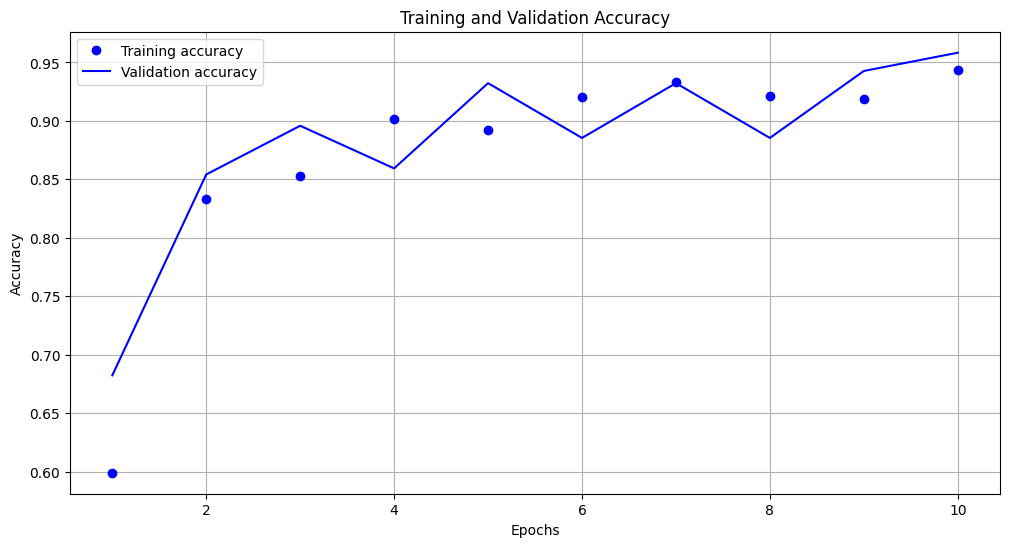

In [63]:
# Extract history data
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9877 - loss: 0.0609
Test accuracy: 0.9871


In [67]:
# Save the model
model.save('model.keras')

In [68]:
loaded_model = tf.keras.models.load_model('model.keras')

In [86]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the model
model = tf.keras.models.load_model('model.keras')  # Load your model

# Define the predict function
def predict(model, img_path, img_size):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = tf.argmax(predictions[0]).numpy()
    confidence = tf.reduce_max(predictions[0]).numpy()

    return predicted_class, confidence, predictions

# Example usage
img_path = 'new.jpg'  # Replace with your image path
img_size = 150  # Replace with your image size

predicted_class, confidence, predictions = predict(model, img_path, img_size)
print("Predicted class:", class_name[predicted_class])
print(f'Confidence:{confidence*100}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicted class: Potato___Late_blight
Confidence:100.0%
